# Lab01. Un problema de clasificación



Existen dos tipos de aprendizaje supervisado en Machine Learining: regresión y clasificación. La primera predice valores continuos y la segunda predice valores discretos. En este notebook nos enfocaremos en la clasificación. 

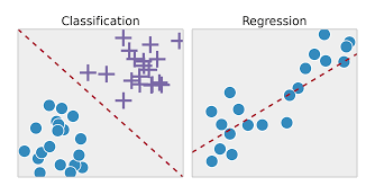

Los algoritmos de clasificación se usan para predecir respuestas que pueden tener solo unos pocos valores conocidos, como casado, soltero o divorciado, según las otras columnas del conjunto de datos. 

A continuación haremos un ejemplo siguiendo todos los pasos necesarios para una clasificación viendo algunos de los diferentes modelos que se emplean:

- [Creación de un entorno virtual](#Creación-de-un-entorno-virtual)
- [Importación de paquetes](#Importación-de-paquetes)
- [Lectura de datos](#Lectura-de-datos)
- [Análisis exploratorio](#Análisis-exploratorio)
- [Procesamiento](#Procesamiento)
- [Obtención del conjunto de entrenamiento y test](#Obtención-del-conjunto-de-entrenamiento-y-test)
- [Construcción de modelos](#Construcción-de-modelos)
- [Validación empleando K-Folds](#Validación-empleando-K-Folds)
- [Entrenamiento en Azure Machine Learning Workspace](#Entrenamiento-en-Azure-Machine-Learning-Workspace)

### Creación de un entorno virtual

Para crear el entorno virtual, tenemos que tener anaconda previamente instalado en nuestro equipo, este programa puede descargarse desde este [link](https://www.anaconda.com/distribution/). 

Una vez descargado e instalado, necesitamos obtener el fichero ``environment.yml`` el cual contiene todas las dependencias tanto de paquetes conda como de paquetes pip que se emplearán. 

- Creación del entorno virtual: este comando nos permite crear el entorno virtual con el nombre y dependencias especificadas en el fichero
``conda env create --file environment.yml``

- Activación del entorno creado:  una vez creado, para activar el entorno creado, será suficiente con hacer
``activate <environment_name>``
- Desactivación del entorno: 
``deactivate <environment_name>``
- Actualización del entorno: para actualizar el entorno con nuevas dependencias (el entorno actual tiene que estar desactivado)
``conda env update --file environment.yml``


En nuestro caso, el ``environment_name`` será ``aiworkshopday2``.

Más comandos útiles de ``conda`` para la gestión de entornos virtuales pueden encontrarse en este [link](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html).

### Importación de paquetes
En primer lugar, hemos de importar los paquetes que vamos a necesitar para este Laboratorio. Para ello, estos han de haber sido previamente instalados en nuestro sistema. Puede consultarse cómo hacerlo en la sección [Creación de un entorno virtual](#Creación-de-un-entorno-virtual).

In [1]:
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core import Workspace, Run
from azureml.core.experiment import Experiment

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import dump
import seaborn as sns
import warnings

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'azureml.core'

### Lectura de datos
Lo primero que hemos de realizar es una lectura de nuestros datos para ver cómo son. 

In [2]:
df = pd.read_csv('data/retail_dataset.csv')
df.head()

,age,workclass,educational_num,marital_status,capital_gain,capital_loss,num_visits_store_last_year,native_country,is_weekend,educational,buy_the_new_product
0,25,Private,7,Own-child,0,0,40,United-States,0,11th,0
1,38,Private,9,Husband,0,0,50,United-States,0,HS-grad,0
2,28,Local-gov,12,Husband,0,0,40,United-States,1,Assoc-admn,1
3,44,Private,10,Husband,7688,0,40,United-States,0,Some-college,1
4,18,?,10,Own-child,0,0,30,United-States,0,Some-college,0


In [3]:
print(df.shape)

(48842, 11)


Vemos que nuestro conjunto de datos tiene un total de 48842 filas y 11 columnas. En estas seis columnas tenemos nuestra variable **target** que es la que queremos predecir, en este caso ``buy_the_new_product``. Vemos también la existencia de valores nulos en la variable ``workclass`` que han de ser manipulados durante el procesamiento.

Dado este conjunto de datos, nuestro **objetivo** será poder predecir si el cliente va a comprar o no un nuevo producto. Estamos por tanto, ante un **problema de clasificación binaria**, es decir, ante nuevos datos, queremos clasificar si un cliente comprará o no un producto.

In [4]:
target = 'buy_the_new_product'


Veamos con más detenimiento las variables independientes que nos ayudarán a predecir ``buy_the_new_product``. Vemos que hay dos tipos de **variables**:
- Continuas
- Categóricas 

Las variables continuas son variables numéricas que pueden tomar un número infinito de valores, como es el caso de las variables ``age``, ``num_visits_store_last_year``, ``capital_gain`` y ``capital_loss``. 

Las variables categóricas son aquellas que pueden tomar un número limitado, y por lo general fijo, de posibles valores. Como serían las variables ``workclass``, ``marital_status`` y ``native_country``.

In [5]:
print(df['workclass'].unique())
print(df['marital_status'].unique())
print(df['native_country'].unique())
print(df['educational'].unique())

['Private' 'Local-gov' '?' 'Self-emp-not-inc' 'Federal-gov' 'State-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
['Own-child' 'Husband' 'Not-in-family' 'Unmarried' 'Wife' 'Other-relative']
['United-States' '?' 'Peru' 'Guatemala' 'Mexico' 'Dominican-Republic'
 'Ireland' 'Germany' 'Philippines' 'Thailand' 'Haiti' 'El-Salvador'
 'Puerto-Rico' 'Vietnam' 'South' 'Columbia' 'Japan' 'India' 'Cambodia'
 'Poland' 'Laos' 'England' 'Cuba' 'Taiwan' 'Italy' 'Canada' 'Portugal'
 'China' 'Nicaragua' 'Honduras' 'Iran' 'Scotland' 'Jamaica' 'Ecuador'
 'Yugoslavia' 'Hungary' 'Hong' 'Greece' 'Trinadad&Tobago'
 'Outlying-US(Guam-USVI-etc)' 'France' 'Holand-Netherlands']
['11th' 'HS-grad' 'Assoc-admn' 'Some-college' ' 10th' 'Prof-school'
 '7th - 8th' 'Bachelor' 'Masters' 'Doctorate' '5th-6th' 'Assoc-voc' '9th'
 '12th' '1st-4th' 'Preschool']


## Análisis exploratorio

Después de haber leído nuestros datos y de haber realizado un breve procesamiento de los mismos, vamos a proceder a realizar el análisis exploratorio. Este paso es muy importante ya que nos permite entender mejor la naturaleza de nuestras variables y ver posibles relaciones entre las mismas, lo que facilitará posteriormente el entrenamiento del modelo. 

El análisis exploratorio se puede dividir en dos partes:

- [Análisis descriptivo](#Análisis-descriptivo)
- [Análisis gráfico](#Análisis-gráfico)

#### Análisis descriptivo

Empecemos con una vista general de nuestros datos, la cual nos dará una intuición de la calidad de los mismos:

In [6]:
print(df.dtypes)
print("Rows     : " , df.shape[0],'\n')
print("Columns  : " , df.shape[1],'\n')
print("\nFeatures :\n" , df.columns.tolist(),'\n')
print("\nMissing values :  \n", df.isnull().sum(),'\n')
print("\nUnique values :\n", df.nunique())  

age                            int64
workclass                     object
educational_num                int64
marital_status                object
capital_gain                   int64
capital_loss                   int64
num_visits_store_last_year     int64
native_country                object
is_weekend                     int64
educational                   object
buy_the_new_product            int64
dtype: object
Rows     :  48842 

Columns  :  11 


Features :
 ['age', 'workclass', 'educational_num', 'marital_status', 'capital_gain', 'capital_loss', 'num_visits_store_last_year', 'native_country', 'is_weekend', 'educational', 'buy_the_new_product'] 


Missing values :  
 age                           0
workclass                     0
educational_num               0
marital_status                0
capital_gain                  0
capital_loss                  0
num_visits_store_last_year    0
native_country                0
is_weekend                    0
educational                 

In [7]:
df.describe()

,age,educational_num,capital_gain,capital_loss,num_visits_store_last_year,is_weekend,buy_the_new_product
count,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,10.078089,1079.067626,87.502314,40.422382,0.265325,0.239016
std,13.710510,2.570973,7452.019058,403.004552,12.391444,0.441511,0.426487
min,17.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000,0.000000,0.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000,0.000000,0.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000,1.000000,0.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000,1.000000,1.000000


Al leer el conjunto de datos, hemos visto que ``?`` indica que el valor es nulo. Veamos si hay más columnas que necesiten una posterior modificación.

In [8]:
for column in df.columns:
    if '?' in df[column].unique():
        print(column)

workclass
native_country


Efectivamente vemos que hay dos columnas con valores nulos: ``workclass`` y ``native_country``. Veamos ahora cuántos valores nulos hay para cada una de las variables.

In [9]:
print(df['workclass'].value_counts())
print(df['native_country'].value_counts())

Private             33906
Self-emp-not-inc     3862
Local-gov            3136
?                    2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64
United-States                 43832
Mexico                          951
?                               857
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia        

Para la variable ``workclass`` hay un total de 2799 valores nulos mientras que para ``native_country`` hay un total de 857.

#### Análisis gráfico
Tras finalizar el análisis descriptivo de nuestro conjunto de datos, en el que vimos el tipo de datos que tenemos y algunos de sus estadísticos, vamos a realizar ahora un análisis gráfico de los mismos para ver qué otras conclusiones podemos extraer de los mismos.

En un problema de clasificación como es el nuestro, es importante ver si nuestro conjunto de datos está balanceado. Esto es, si tiene aproximadamente el mismo número de datos para cada una de las clases en las que se quiere clasifiacar. Se estudia a continuación el balanceo de nuestros datos:

In [10]:
print(df.groupby(target).size())

buy_the_new_product
0    37168
1    11674
dtype: int64


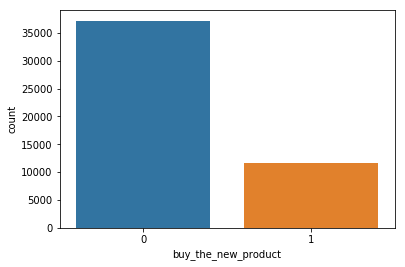

In [11]:
sns.countplot(df[target],label="Count")
plt.show()

En esta gráfica vemos que hay más cantidad de gente que no compró el producto que aquellos que sí. Sin embargo, no parece que esto vaya a ser un problema, pues los problemas relativos al desbalanceo de nuestros datos suelen venir cuando esta diferencia es más acusada.

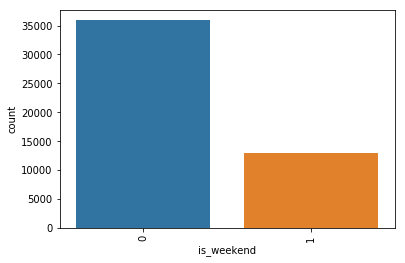

In [12]:
sns.countplot(df['is_weekend'],label="Count")
plt.xticks(rotation=90)
plt.show()

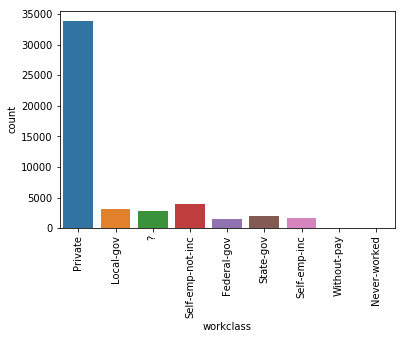

In [13]:
sns.countplot(df['workclass'],label="Count")
plt.xticks(rotation=90)
plt.show()

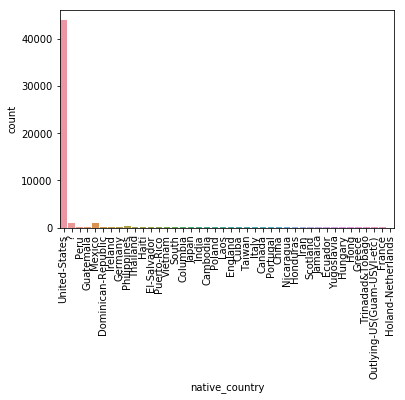

In [14]:
sns.countplot(df['native_country'],label="Count")
plt.xticks(rotation=90)
plt.show()

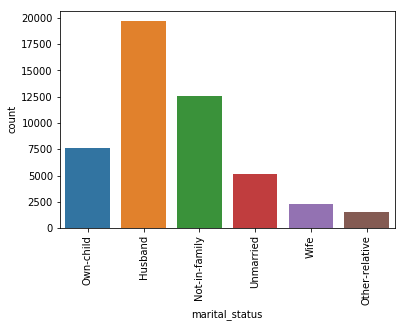

In [15]:
sns.countplot(df['marital_status'],label="Count")
plt.xticks(rotation=90)
plt.show()

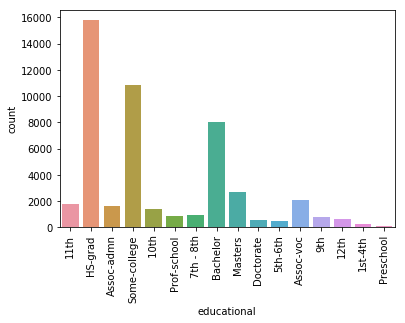

In [16]:
sns.countplot(df['educational'],label="Count")
plt.xticks(rotation=90)
plt.show()

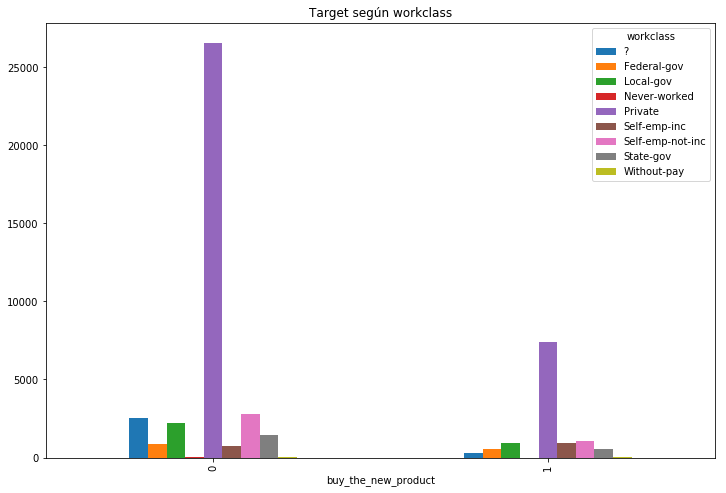

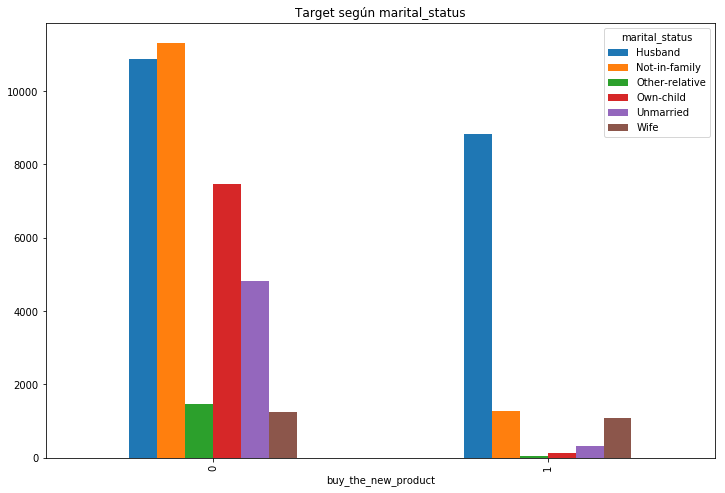

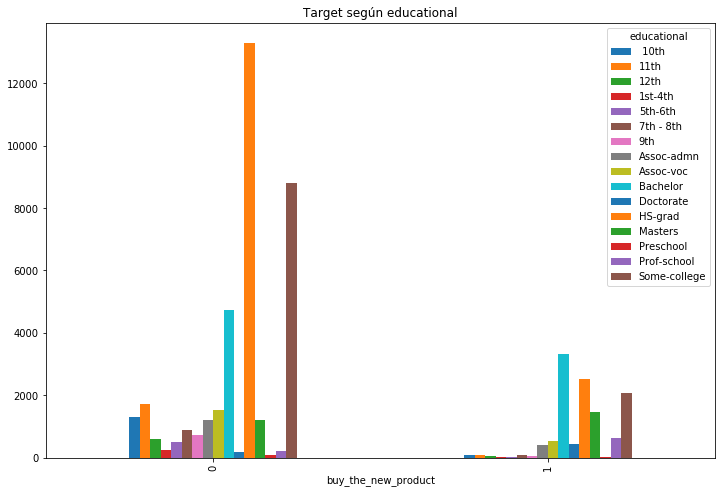

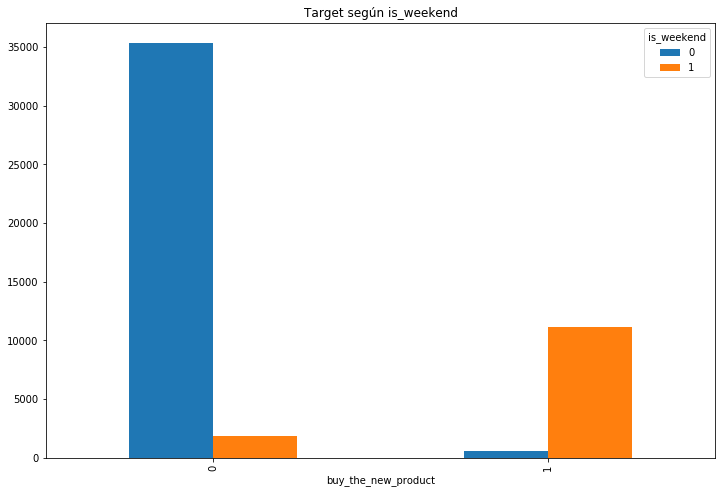

In [17]:
cat_columns = ['workclass', 'marital_status', 'educational', 'is_weekend']
for column in cat_columns:
    pd.crosstab(df[target], df[column]).plot(kind='bar', figsize=(12,8))
    plt.title('Target según {}'.format(column))
    plt.show()

#### Funciones de densidad

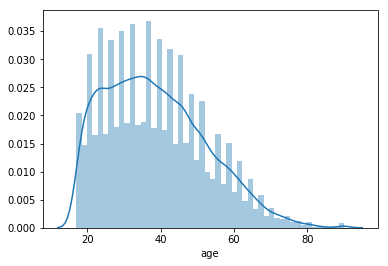

In [18]:
ax = sns.distplot(df['age'])
plt.show()

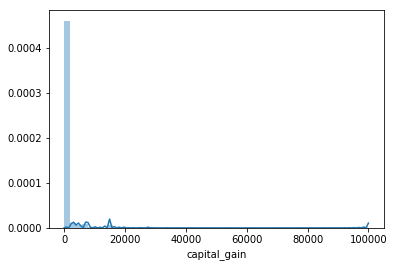

In [19]:
ax = sns.distplot(df['capital_gain'])
plt.show()

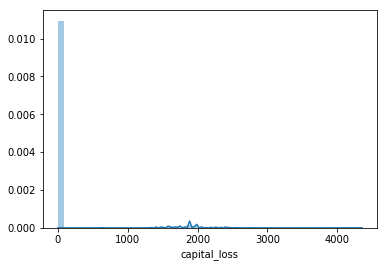

In [20]:
ax = sns.distplot(df['capital_loss'])
plt.show()

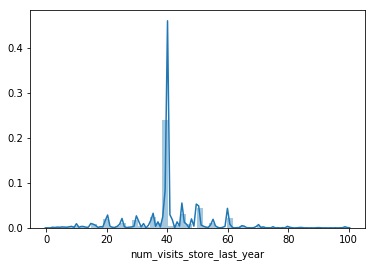

In [21]:
ax = sns.distplot(df['num_visits_store_last_year'])
plt.show()

#### Boxplot

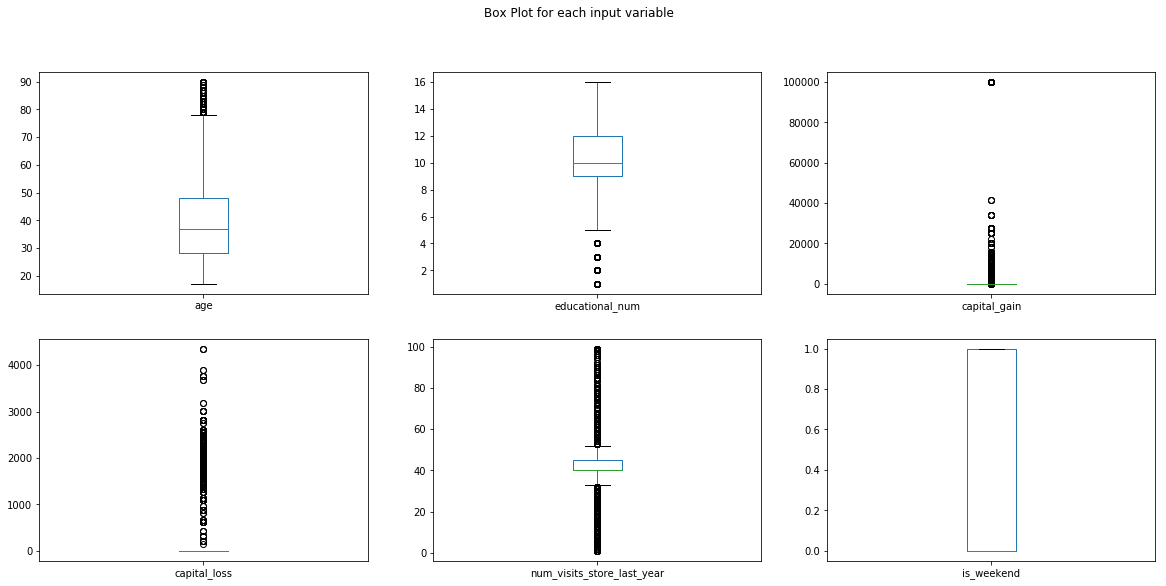

In [22]:
df.drop(target, axis=1).plot(kind='box', subplots=True, layout=(2,3), sharex=False, sharey=False, figsize=(20,9), 
                                        title='Box Plot for each input variable')
plt.show()

#### Gráfico de dispersión e histograma 

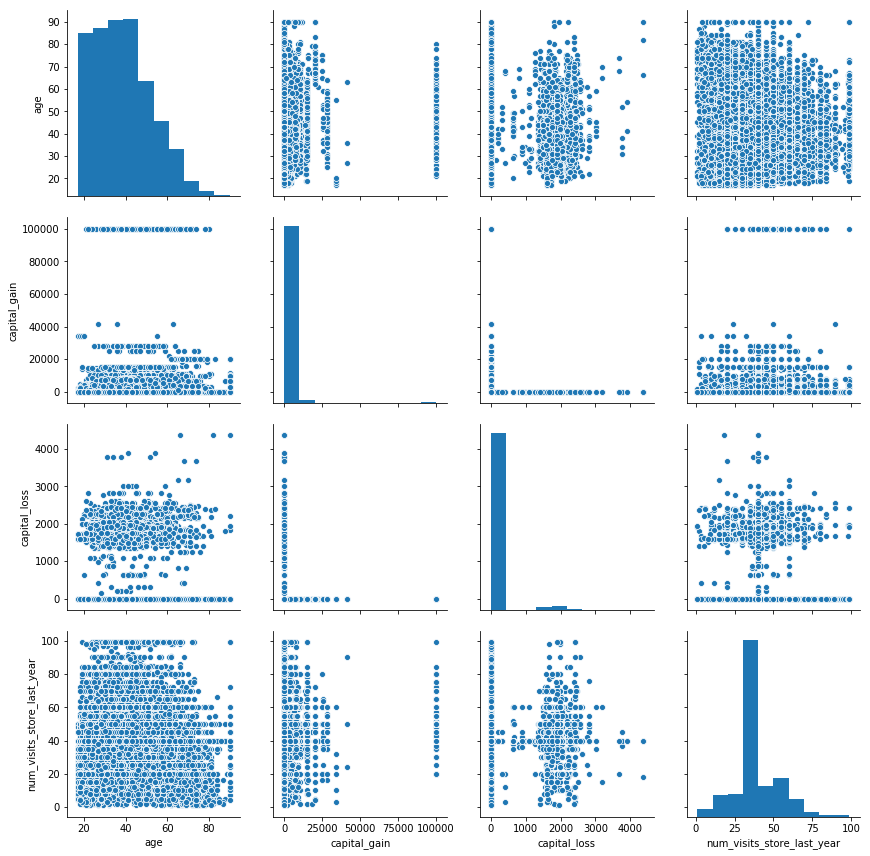

In [23]:
feature_names = ['age', 'capital_gain', 'capital_loss', 'num_visits_store_last_year']
X = df[feature_names]
sns.pairplot(X,height=3)
plt.show()

#### Correlación
Una vez se ha obtenido el conjunto de datos total, se procede a estudiar la existencia de relaciones entre las diferentes variables consideradas. Como el objetivo final del problema a tratar es ser capaces de predecir las ventas de un producto. Las conclusiones obtenidas se centrarán en las relaciones de la variable respuesta (``buy_the_new_product``) con las otras, que como dijimos reciben el nombre de variables explicativas.

Para ello se calculará la matriz de correlación para el conjunto total de nuestros datos. La matriz de correlaciones es una matriz en la cual cada entrada presenta el coeficiente de correlación entre dos variables.

El coeficiente de correlación de Pearson es una medida estadística que permite conocer el grado de asociación lineal entre dos variables cuantitativas $(X,Y)$. Éste se calcula como la covarianza de dos variables dividida por el producto de la desviación típica de cada una de las muestras. Es la normalización de la covarianza entre dos variables. 

El coeficiente de correlación toma valores entre $-1$ y $1$. Si el valor del coeficiente de correlación es $1$ o próximo a $1$, se dirá que la asociación lineal es positiva (esto es, a medida que crece una de las variables crece la otra), de la misma forma, cuando el valor es próximo a $-1$, se dice que la asociación lineal es negativa. La matriz de correlación se representará empleando un mapa de colores, lo que permite ver a simple vista el grado de correlación entre las distintas variables.

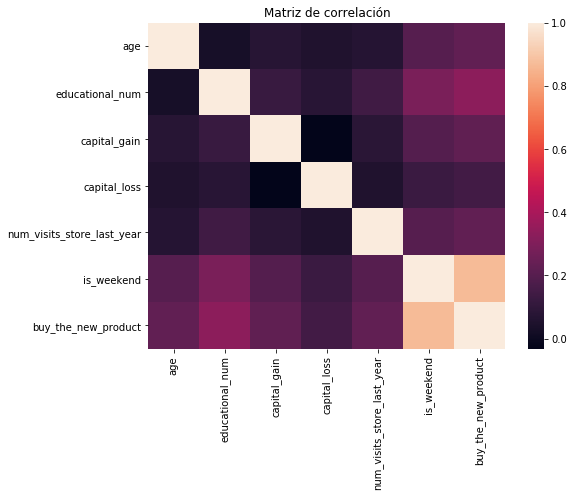

In [24]:
plt.figure(figsize=(8, 6))
corr = df.corr(method ='pearson')
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.title('Matriz de correlación')
plt.show()

Si nos fijamos en el mapa de colores, vemos que la variable ``is_weekend`` está altamente correlada con la variable de interés. Debido a esto, será eliminada para entrenar los modelos sin ella, ya que si no, estos podrían fijarse únicamene en esta variable y no tener en cuenta la inversión que se está haciendo en privacidad para predecir el número de ventas. 

### Procesamiento

In [25]:
df_prep = df.copy()

#### Eliminación de variables:

In [26]:
df_prep.drop(['educational'], axis=1, inplace=True)
df_prep.drop(['is_weekend'], axis=1, inplace=True)
df_prep.head()

,age,workclass,educational_num,marital_status,capital_gain,capital_loss,num_visits_store_last_year,native_country,buy_the_new_product
0,25,Private,7,Own-child,0,0,40,United-States,0
1,38,Private,9,Husband,0,0,50,United-States,0
2,28,Local-gov,12,Husband,0,0,40,United-States,1
3,44,Private,10,Husband,7688,0,40,United-States,1
4,18,?,10,Own-child,0,0,30,United-States,0


#### Rellenamos valores nulos:
Hay diferentes técnicas para tratar los valores nulos, cuando son pocos, estos pueden ser eliminados. En este caso, vamos a emplear otra técnica que consiste en substituír el valor nulo por la moda de los valores que toma esa variable. La moda es el valor que más veces se repite.

In [27]:
df_prep['workclass'][df_prep['workclass'] == '?']=df_prep['workclass'].value_counts().index[0]
df_prep['native_country'][df_prep['native_country'] == '?']=df_prep['native_country'].value_counts().index[0]

df_prep.head()

,age,workclass,educational_num,marital_status,capital_gain,capital_loss,num_visits_store_last_year,native_country,buy_the_new_product
0,25,Private,7,Own-child,0,0,40,United-States,0
1,38,Private,9,Husband,0,0,50,United-States,0
2,28,Local-gov,12,Husband,0,0,40,United-States,1
3,44,Private,10,Husband,7688,0,40,United-States,1
4,18,Private,10,Own-child,0,0,30,United-States,0


#### Conversión a valores numéricos:
Hemos visto que tenemos algunas variables que son categóricas, estas, para que puedan ser entendidas por nuestro algoritmo , han de ser convertidas a numéricas, que es lo que se realiza a continuación:

In [28]:
df_prep['workclass'] = df_prep['workclass'].astype('category').cat.codes
df_prep['native_country'] = df_prep['native_country'].astype('category').cat.codes
df_prep['marital_status'] = df_prep['marital_status'].astype('category').cat.codes

df_prep.head()

,age,workclass,educational_num,marital_status,capital_gain,capital_loss,num_visits_store_last_year,native_country,buy_the_new_product
0,25,3,7,3,0,0,40,38,0
1,38,3,9,0,0,0,50,38,0
2,28,1,12,0,0,0,40,38,1
3,44,3,10,0,7688,0,40,38,1
4,18,3,10,3,0,0,30,38,0


Una vez que estas variables han sido modificadas a numéricas, podemos también estudiar su relación con las demás.

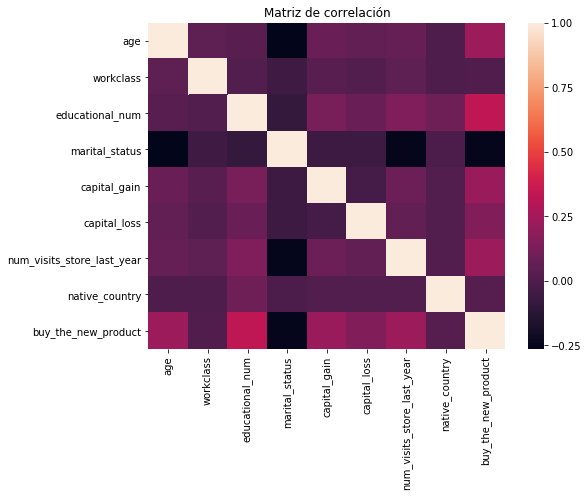

In [29]:
plt.figure(figsize=(8, 6))
corr = df_prep.corr(method ='pearson')
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.title('Matriz de correlación')
plt.show()

### Obtención del conjunto de entrenamiento y test

Antes de entrenar cualquier modelo de *Machine Learning* o de *Deep Learning* debemos dividir nuestro conjunto de datos en dos o tres grandes subconjuntos: el conjunto de entrenamiento y test y, en algunos casos, el conjunto de validación. Veamos para qué sirve cada uno de estos conjuntos:
- Conjunto de entrenamiento: este conjunto será empleado, como su nombre indica, para entrenar los diferentes modelos.
- Conjunto de test: es una última porción que se mantiene aparte y sobre la cual se evalua el modelo. Usualmente se reporta la eficacia del modelo según los resultados en este conjunto. 

Los porcentajes de los datos que se emplean en cada uno de los conjuntos pueden variar si bien para el conjunto de entrenamiento se suelen unsar un 50% o más, usualmente hasta un 80%.

Expliquemos ahora brevemente en qué consiste el conjunto de validación, el cuál se obtiene mediante el empleo de validación cruzada de $K$ iteraciones. Esta técnica consiste en subdivir nuestro conjunto de entrenamiento en en $K$ subconjuntos. Uno de los subconjuntos se utiliza como datos de prueba y el resto ($K-1$) como datos de entrenamiento. El proceso de validación cruzada es repetido durante k iteraciones, con cada uno de los posibles subconjuntos de datos de prueba. Esto nos ayuda monitorizar el entrenamiento y evitar que el modelo sobre o infra-ajuste:
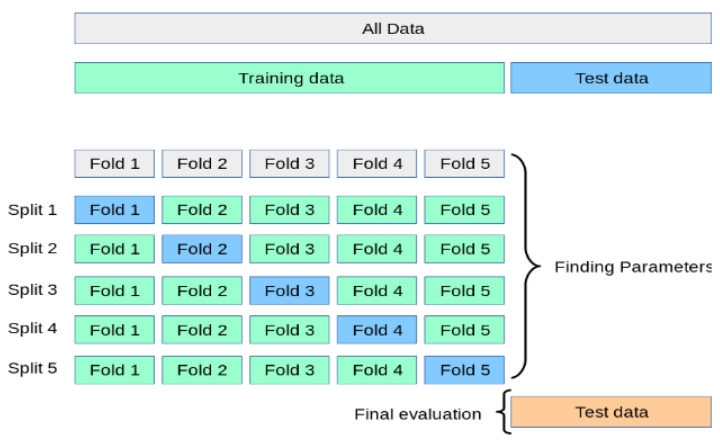
* Se llama **overfitting** al sobreentrenamiento de un modelo, esto ocurre cuando el modelo memoriza los datos y ya no es capaz de generalizar. Si esto ocurre el modelo no será capaz de dar buenos resultados con nuevos datos. 
* se le llama **underfitting** a un modelo que no ha sido entrenado suficientemente con lo cual no ha sido capaz de abstraer las relaciones de los datos necesarias para poder hacer buenas predicciones. 

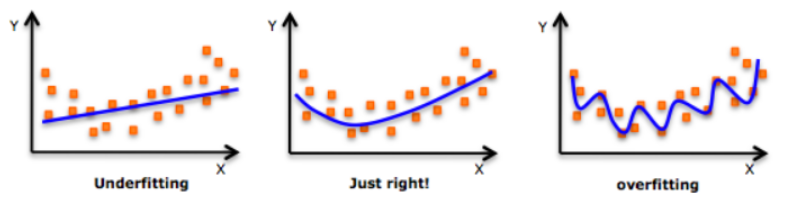

In [30]:
x = df_prep.drop([target], axis=1)
y = df_prep[target]

msk = np.random.rand(len(df_prep))<0.8

x_train = x[msk]
y_train= y[msk]

x_test = x[~msk]
y_test = y[~msk]

## Construcción de modelos

- [Regresión logística](#Regresión-logística)
- [Árbol de decisión](#Árbol-de-decisión)
- [K-Neighbors](#K-neighbors)

#### Regresión logística
La regresión logística es un tipo de regresión utilizado para predecir el resultado de una variable categórica (una variable que puede adoptar un número limitado de categorías) en función de las variables independientes o predictoras.

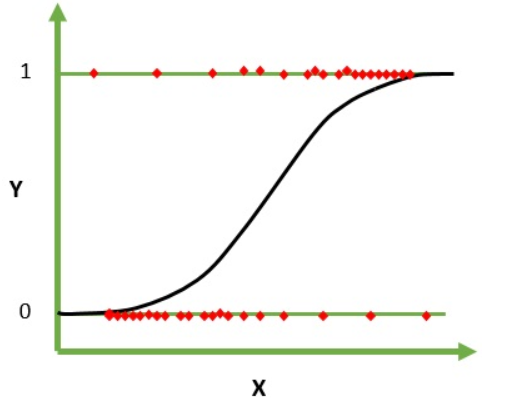


In [31]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

####  Árbol de decisión
Un árbol de decisión es un modelo predictivo que mapea observaciones sobre un un elemento sobre el valor objetivo de dicho elementos. Cuando la variable de destino puede tomar un conjunto finito de valores se denominan árboles de clasificación. En estas estructuras de árbol, las hojas representan etiquetas de clase y las ramas representan las conjunciones de características que conducen a esas etiquetas de clase.
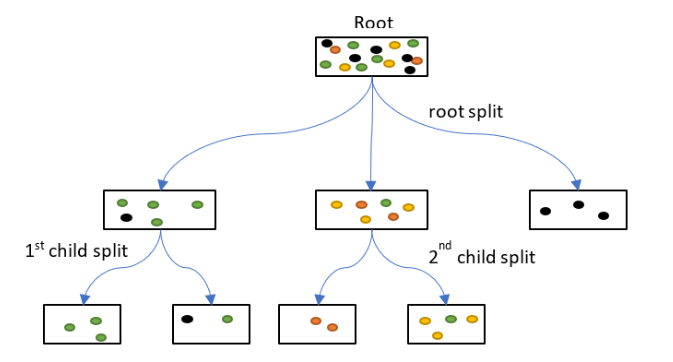

In [32]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

####  K-Neighbors classifier
El algoritmo K-nearest neighbors (k-NN) es un método no paramétrico usado tanto para clasificación como regresión. Es usado como un método de clasificación basado en un entrenamiento mediante ejemplos cercanos en el espacio de los elementos. Cuando es empleado como método de clasificación, la salida es la pertenencia o no a la clase en la que se quiere clasificar el elemento. 
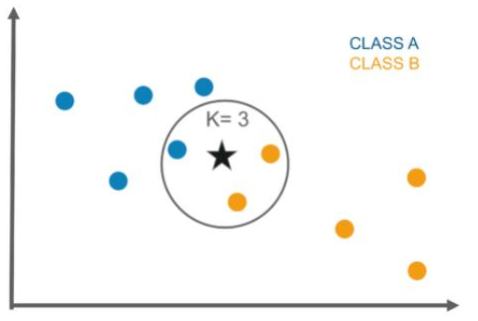

In [33]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

### Entrenamiento en Azure Machine Learning Workspace

En primer lugar, tenemos que realizar la conexión con el servicio. Para realizar esta conexión se necesita el ID de la subscripción, el grupo de recursos en el que se encuentra el servicio y el nombre del workspace:

In [34]:
ws = Workspace.from_config(path="config/azureml_ws.json")

In [35]:
def plot_confusion_matrix(confusion_mat):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion_mat)
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    return plt

#### Regresión logística

In [36]:
experiment_name = 'day2-logisticregression'
model_name = 'logisticregression.pkl'
exp = Experiment(workspace=ws, name=experiment_name)
root_run = exp.start_logging()

Converted key confusion_matrix of value [[7029  348]
 [1434  929]] to array([[7029,  348],
       [1434,  929]], dtype=int64).



[[7029  348]
 [1434  929]]
             precision    recall  f1-score   support

          0       0.83      0.95      0.89      7377
          1       0.73      0.39      0.51      2363

avg / total       0.81      0.82      0.80      9740



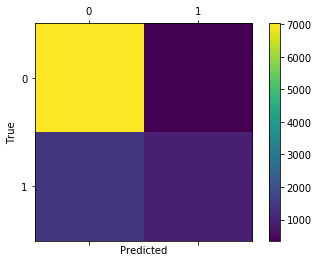

In [38]:
logreg = LogisticRegression()
kf = KFold(n_splits=3) 

i=0
for train_index, test_index in kf.split(x_train):
    i=i+1
    X, X_val, Y, Y_val = x_train.iloc[train_index], x_train.iloc[test_index], y_train.iloc[train_index], y_train.iloc[test_index]
    logreg.fit(X, Y)
    pred=logreg.predict(X_val)
    val_accuracy = accuracy_score(Y_val, pred)
    root_run.log(str(i)+' Fold val accuracy:', val_accuracy)


pred = logreg.predict(x_test)
confusion_mat = confusion_matrix(y_test, pred)
class_report = classification_report(y_test, pred)
accuracy = accuracy_score(y_test, pred)

print(confusion_mat)
print(class_report)

root_run.log("confusion_matrix", confusion_mat)    
root_run.log("classification_report", class_report)
root_run.log("Accuracy", accuracy)

plt = plot_confusion_matrix(confusion_mat)
plt.savefig('images/confusion_matrix.png', bbox_inches='tight')

root_run.log_image('confusion_matrix', path='images/confusion_matrix.png')

dump(logreg, model_name)
    
root_run.upload_file("outputs/" + model_name, model_name)
root_run.register_model(model_name=model_name, model_path='outputs/' + model_name)
root_run.complete()

#### Árbol de decisión

In [39]:
experiment_name = 'day2-decisiontreeclassifier'
model_name = 'decisiontreeclassifier.pkl'
exp = Experiment(workspace=ws, name=experiment_name)
root_run = exp.start_logging()

Converted key confusion_matrix of value [[6667  710]
 [1028 1335]] to array([[6667,  710],
       [1028, 1335]], dtype=int64).



[[6667  710]
 [1028 1335]]
             precision    recall  f1-score   support

          0       0.87      0.90      0.88      7377
          1       0.65      0.56      0.61      2363

avg / total       0.81      0.82      0.82      9740



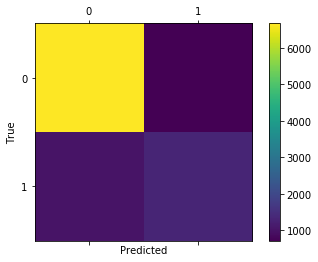

In [40]:
clf = DecisionTreeClassifier()
kf = KFold(n_splits=3) 

i=0
for train_index, test_index in kf.split(x_train):
    i=i+1
    X, X_val, Y, Y_val = x_train.iloc[train_index], x_train.iloc[test_index], y_train.iloc[train_index], y_train.iloc[test_index]
    clf.fit(X, Y)
    pred=clf.predict(X_val)
    val_accuracy = accuracy_score(Y_val, pred)
    root_run.log(str(i)+' Fold val accuracy:', val_accuracy)


pred = clf.predict(x_test)
confusion_mat = confusion_matrix(y_test, pred)
class_report = classification_report(y_test, pred)
accuracy = accuracy_score(y_test, pred)

print(confusion_mat)
print(class_report)

root_run.log("confusion_matrix", confusion_mat)    
root_run.log("classification_report", class_report)
root_run.log("Accuracy", accuracy)

plt = plot_confusion_matrix(confusion_mat)
plt.savefig('images/confusion_matrix.png', bbox_inches='tight')

root_run.log_image('confusion_matrix', path='images/confusion_matrix.png')

dump(clf, model_name)
    
root_run.upload_file("outputs/" + model_name, model_name)
root_run.register_model(model_name=model_name, model_path='outputs/' + model_name)
root_run.complete()

#### K-Neighbors

In [41]:
experiment_name = 'day2-knnclassifier'
model_name = 'knnclassifier.pkl'
exp = Experiment(workspace=ws, name=experiment_name)


Converted key confusion_matrix of value [[6831  546]
 [1057 1306]] to array([[6831,  546],
       [1057, 1306]], dtype=int64).



[[6831  546]
 [1057 1306]]
             precision    recall  f1-score   support

          0       0.87      0.93      0.89      7377
          1       0.71      0.55      0.62      2363

avg / total       0.83      0.84      0.83      9740



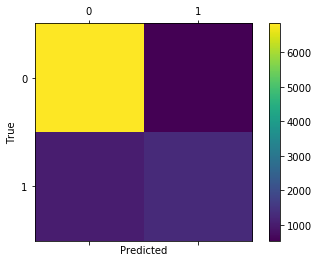

In [42]:
root_run = exp.start_logging()
knn = KNeighborsClassifier()
kf = KFold(n_splits=3) 

i=0
for train_index, test_index in kf.split(x_train):
    i=i+1
    X, X_val, Y, Y_val = x_train.iloc[train_index], x_train.iloc[test_index], y_train.iloc[train_index], y_train.iloc[test_index]
    knn.fit(X, Y)
    pred=knn.predict(X_val)
    val_accuracy = accuracy_score(Y_val, pred)
    root_run.log(str(i)+' Fold val accuracy:', val_accuracy)


pred = knn.predict(x_test)
confusion_mat = confusion_matrix(y_test, pred)
class_report = classification_report(y_test, pred)
accuracy = accuracy_score(y_test, pred)

print(confusion_mat)
print(class_report)

root_run.log("confusion_matrix", confusion_mat)    
root_run.log("classification_report", class_report)
root_run.log("Accuracy", accuracy)

plt = plot_confusion_matrix(confusion_mat)
plt.savefig('images/confusion_matrix.png', bbox_inches='tight')

root_run.log_image('confusion_matrix', path='images/confusion_matrix.png')

dump(knn, model_name)
    
root_run.upload_file("outputs/" + model_name, model_name)
root_run.register_model(model_name=model_name, model_path='outputs/' + model_name)
root_run.complete()